# Introduction to Machine Learning (Lab 12)

- Instructor: Jaemin Jo (Sungkyunkwan University)
- TA: Jaeung Lee (Sungkyunkwan University)
- Topics to cover: Softmax Regression, Neural Network and Backpropagation

## 1. Softmax Regression

### 1.1. Packages
- [numpy](https://www.numpy.org): Fundamental package for scientific computing with Python.
- [matplotlib](https://matplotlib.org): A comprehensive library for creating static, animated, and interactive visualizations in Python.
- [scikit-learn](https://scikit-learn.org): A library for machine learning in Python.

In [ ]:
!pip install numpy matplotlib scikit-learn

### 1.2 Problem Statement
[Wine Dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#wine-dataset)

The Wine Dataset is a classic dataset in machine learning that contains chemical analysis results of wines grown in the same region in Italy but derived from three different cultivars. In this part, we will fit a softmax regression model to classify the wines into their respective cultivars!

Each sample in the dataset has the following attributes:
- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
- Proline
  
The task is to predict the cultivar (Barolo, Grignolino, or Barbera) of the wine based on these 13 chemical measurements.



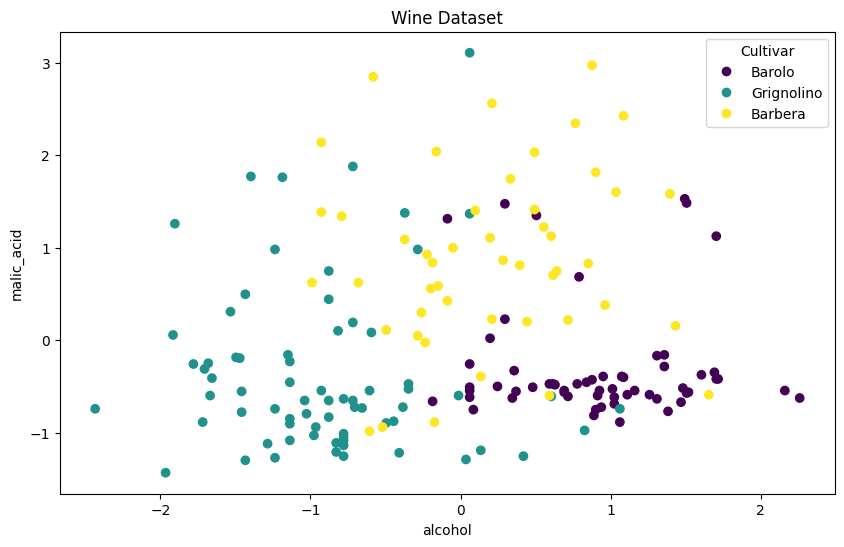

Dataset size: (178, 2)
Number of classes: 3


In [1]:
# Load wine dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

wine = load_wine()
X = wine.data[:, [0, 1]]  # Use only first two features (alcohol, malic_acid)
y = wine.target

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Data visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y)
plt.legend(handles=scatter.legend_elements()[0],
          labels=['Barolo', 'Grignolino', 'Barbera'],
          title='Cultivar')
plt.xlabel(wine.feature_names[0])
plt.ylabel(wine.feature_names[1])
plt.title('Wine Dataset')
plt.show()

print('Dataset size:', X.shape)
print('Number of classes:', len(np.unique(y)))

### 1.3. Softmax Function
 The softmax function is defined as:

 $$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}$$

 However, when implementing softmax, we subtract the maximum value from each input for numerical stability:

 $$\text{softmax}(z_i) = \frac{e^{z_i-\max(z)}}{\sum_{j=1}^K e^{z_j-\max(z)}}$$
 This is mathematically equivalent because:

$$\frac{e^{z_i-\max(z)}}{\sum_{j=1}^K e^{z_j-\max(z)}} = \frac{e^{z_i}/e^{\max(z)}}{(\sum_{j=1}^K e^{z_j})/e^{\max(z)}} = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}$$

 By subtracting the maximum value, we prevent potential numerical overflow while maintaining the same mathematical result.


In [2]:
def softmax(z):
    # Subtract maximum value for numerical stability
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

### 1.4. Cross Entropy Loss
Binary Cross Entropy (BCE) loss, which we learned previously, is used for binary classification:
$$\text{BCE} = -\frac{1}{N}\sum_{i=1}^N [y_i\log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)]$$
Cross Entropy (CE) loss is a generalization of BCE for multi-class classification tasks and is defined as:
$$\text{Cross Entropy Loss} = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^K y_{ij}\log(\hat{y}_{ij})$$
where:
- $N$ is the number of samples
- $K$ is the number of classes
- $y_{ij}$ is the true label (1 if sample i belongs to class j, 0 otherwise)
- $\hat{y}_{ij} = \text{softmax}(z_{ij}) = \frac{e^{z_{ij}}}{\sum_{k=1}^K e^{z_{ik}}}$ is the predicted probability after applying softmax
  
Note that BCE is a special case of CE where K=2.

In [3]:
def cross_entropy_loss(y_pred, y_true):
    # One-hot encoding
    n_samples = y_true.shape[0]
    y_true_one_hot = np.zeros((n_samples, y_pred.shape[1]))
    y_true_one_hot[np.arange(n_samples), y_true] = 1

    # Calculate cross entropy loss
    return -np.sum(y_true_one_hot * np.log(y_pred + 1e-8)) / n_samples

### 1.5. Backward Pass for Softmax Regression

The key insight in the backward pass is that when we combine the derivatives of softmax and cross-entropy loss, we get a surprisingly simple form:

$$\frac{\partial L}{\partial z_{ij}} = \hat{y}_{ij} - y_{ij}$$

Then using the chain rule, we get the final gradients:

For weights W:
$$\frac{\partial L}{\partial W} = \frac{1}{N}X^T(\hat{y} - y)$$

This comes from:
1. Chain rule: $\frac{\partial L}{\partial W} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial W}$
2. Since $z = XW$, we have $\frac{\partial z}{\partial W} = X^T$
3. Therefore: $\frac{\partial L}{\partial W} = X^T \cdot (\hat{y} - y)$
4. Normalize by batch size N

For bias b:
$$\frac{\partial L}{\partial b} = \frac{1}{N}\sum(\hat{y} - y)$$

where:
- $N$ = number of samples
- $X$ = input features matrix
- $\hat{y}$ = softmax output (predicted probabilities)
- $y$ = true labels in one-hot encoded form

In [4]:
def backward_pass(X, y_pred, y, n_samples, n_classes):
    # Convert true labels to one-hot encoding
    y_true_one_hot = np.zeros((n_samples, n_classes))
    y_true_one_hot[np.arange(n_samples), y] = 1

    # Calculate gradients
    dz = y_pred - y_true_one_hot
    dW = np.dot(X.T, dz) / n_samples
    db = np.sum(dz, axis=0, keepdims=True) / n_samples

    return dW, db

### Exercise 1. Softmax Regression
Softmax Regression extends logistic regression for multi-class classification.
Key equations:
1. Linear transformation: $$z = WX + b$$
2. Softmax function: $$P(y=j|x) = \frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}}$$
3. Cross Entropy Loss: $$L = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^K y_{ij}\log(\hat{y}_{ij})$$
4. Weight update: $$W := W - \alpha\frac{\partial L}{\partial W}$$

Pros:
- Simple and interpretable
- Fast and efficient
- Easy to implement

Cons:
- Cannot learn non-linear boundaries
- Not flexible for complex datasets

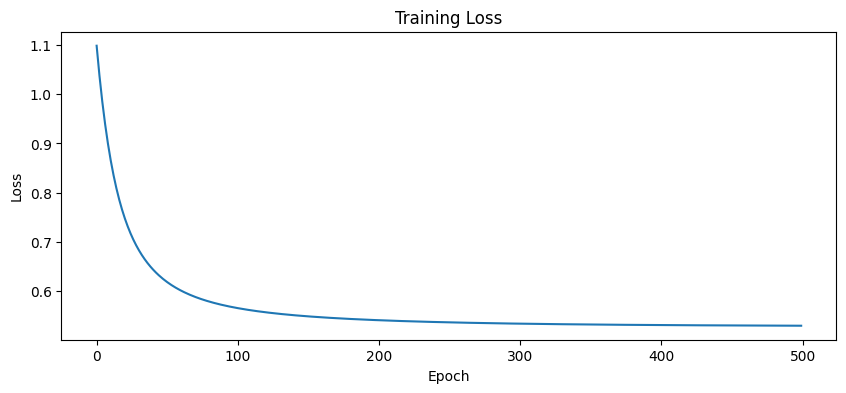

In [5]:
def softmax_regression(X, y, learning_rate=0.1, epochs=1000):
    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))

    # Initialize weights and bias
    W = np.random.randn(n_features, n_classes) * 0.01
    b = np.zeros((1, n_classes))

    losses = []

    for epoch in range(epochs):
        # Forward pass (Linear transformation and softmax)
        z = np.dot(X, W) + b
        y_pred = softmax(z)

        # Calculate loss
        loss = cross_entropy_loss(y_pred, y)
        losses.append(loss)

        # Backward pass
        dW, db = backward_pass(X, y_pred, y, n_samples, n_classes)

        # Update weights
        W -= learning_rate * dW
        b -= learning_rate * db

    return W, b, losses

# Train model
W, b, losses = softmax_regression(X, y, learning_rate=0.1, epochs=500)

# Loss plot
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

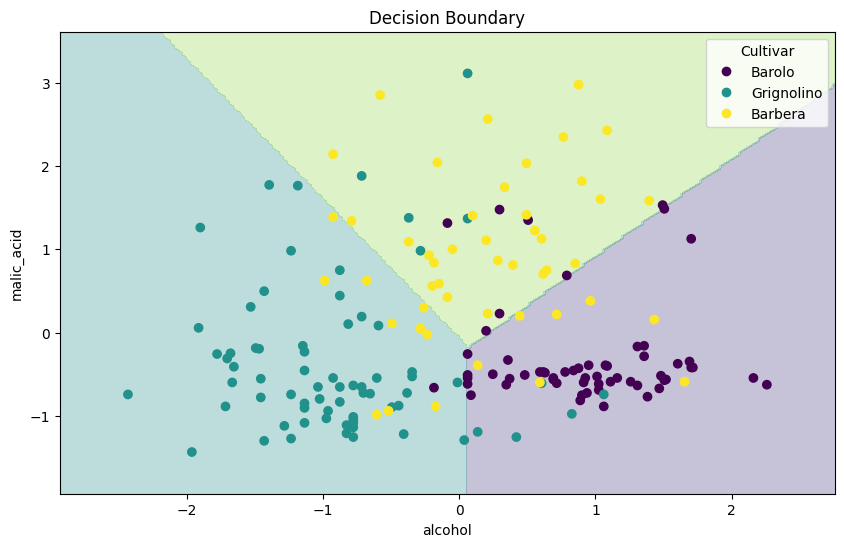

Accuracy: 0.7809


In [6]:
# Visualize decision boundary
def plot_decision_boundary(X, y, W, b):
    # Create a finer grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))

    # Prediction
    Z = softmax(np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b)
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(4)-0.5)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    plt.legend(handles=scatter.legend_elements()[0],
              labels=['Barolo', 'Grignolino', 'Barbera'],
              title='Cultivar')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.title('Decision Boundary')
    plt.show()

plot_decision_boundary(X, y, W, b)

# Calculate accuracy
y_pred = np.argmax(softmax(np.dot(X, W) + b), axis=1)
accuracy = np.mean(y_pred == y)
print(f'Accuracy: {accuracy:.4f}')

## 2. Neural Network and Backpropagation (Multi-layer perceptron)


### 2.1. Generate Spiral Dataset
In this section, we'll create a spiral dataset to demonstrate non-linear classification:
- The dataset consists of points arranged in spiral patterns
- Each spiral represents a different class
- The classes cannot be separated by simple lines or planes for showing why we need neural networks
- Simple models like logistic regression would struggle with this data
  
Reference: https://cs231n.github.io/neural-networks-case-study/

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
from sklearn.model_selection import train_test_split

def generate_spiral_data(n_points, n_features, n_classes):
    np.random.seed(527)
    X = np.zeros((n_points*n_classes, n_features))
    y = np.zeros((n_points*n_classes,), dtype=np.uint8)
    for j in range(n_classes):
        i = range(n_points*j, n_points*(j+1))
        r = np.linspace(0., 1, n_points) # radius
        t = np.linspace(j*4, (j+1)*4, n_points) + np.random.randn(n_points) * 0.2 # theta
        X[i] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[i] = j
    return train_test_split(X, y, test_size=0.2, random_state=444)

def plot_spiral(X, y, x1_mesh=None, x2_mesh=None, y_mesh=None):
    x1, x2 = X[:, 0], X[:, 1]
    plt.figure(figsize=(10, 6))
    plt.scatter(x1[y==0], x2[y==0], c='tab:blue', marker='o', label='class:0')
    plt.scatter(x1[y==1], x2[y==1], c='tab:orange', marker='^', label='class:1')
    plt.scatter(x1[y==2], x2[y==2], c='tab:green', marker='x', label='class:2')
    if x1_mesh is not None:
        cmap = mplcolors.ListedColormap(['tab:blue', 'tab:orange', 'tab:green'])
        plt.contourf(x1_mesh, x2_mesh, y_mesh, levels=3, cmap=cmap, alpha=0.3)
    plt.title('MLP (Spiral dataset)', fontsize=18, pad=12)
    plt.xlabel('x1', fontsize=16, labelpad=12)
    plt.ylabel('x2', fontsize=16, labelpad=12)
    plt.legend(fontsize=14, loc='upper left')
    plt.show()

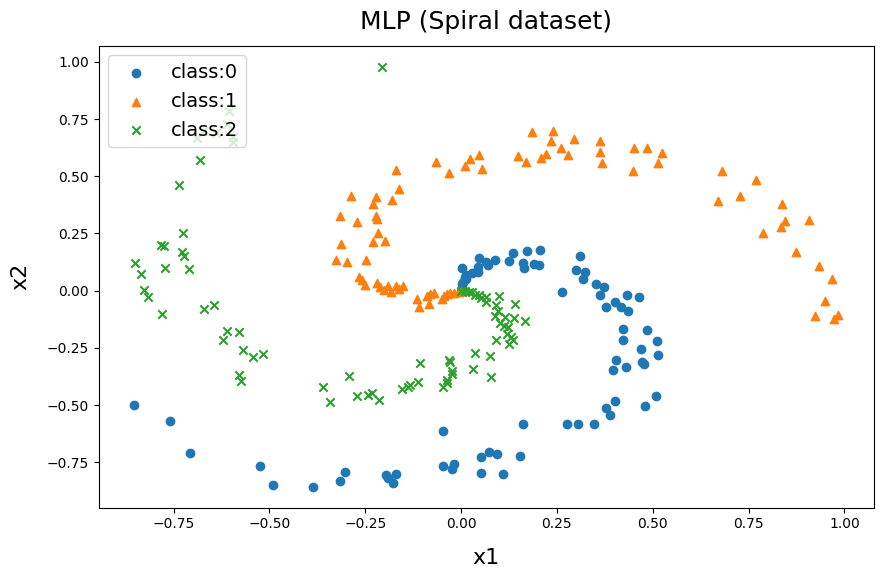

In [8]:
x_train, x_test, y_train, y_test = generate_spiral_data(n_points=100, n_features=2, n_classes=3)
plot_spiral(x_train, y_train)

### 2.2. ReLU
The ReLU (Rectified Linear Unit) layer implements a simple non-linear activation function that helps neural networks learn complex patterns. It works by keeping positive values unchanged and setting negative values to zero.

Key components:
1. **Forward Pass**:
   - Takes input x and applies the ReLU function element-wise: $$f(x) = max(0,x)$$
   - Stores the input in memory for the backward pass
2. **Backward Pass**:
   - Receives gradient dout from the next layer
   - Computes gradient based on the stored input: $$f'(x) = \begin{cases} 1 & \text{if } x > 0 \\ 0 & \text{otherwise} \end{cases}$$
   - Returns: $$dx = dout * (x > 0)$$

In [9]:
class ReLU:
    def __call__(self, x):
        self.input = x # cache for backward
        out = np.maximum(0, x)
        return out

    def backward(self, dout):
        dx = dout * (self.input > 0)
        return dx

### Exercise 2. Linear Layer Implementation

The Linear layer implements a basic neural network layer that performs an affine transformation: $y = xW + b$

Key components:
1. **Initialization**:
   - Weights (W): $W \sim U(0,1)$
   - Biases (b): $b = 0$
   - Shape: $W \in \mathbb{R}^{in\_features \times out\_features}, b \in \mathbb{R}^{out\_features}$

2. **Forward Pass**:
   - Computes the affine transform: $output = xW + b$
   - Caches input for backward pass

3. **Backward Pass**:
   - dout: Gradient of the loss with respect to the layer's output ($\frac{\partial L}{\partial out}$)
    - Weights gradient: $\frac{\partial L}{\partial W}$ = $\frac{\partial L}{\partial out} \cdot \frac{\partial out}{\partial W}$ = $\frac{\partial L}{\partial out} \cdot x$ = $x^T \cdot \frac{\partial L}{\partial out}$
   - Bias gradient: $\frac{\partial L}{\partial b} = \sum \frac{\partial L}{\partial out}$
   - Input gradient: $\frac{\partial L}{\partial x} = \frac{\partial L}{\partial out} \cdot W^T$

In [18]:
class Linear:
    def __init__(self, in_features, out_features, is_first=False):
        self.w = np.random.uniform(0, 1, (in_features, out_features))
        self.b = np.zeros((1, out_features))
        self.dw = None
        self.db = None
        self.is_first = is_first

    def __call__(self, x):
        self.input = x  # cache for backward
        return np.dot(x, self.w) + self.b

    def backward(self, dout):
        # Compute gradients
        self.dw = np.dot(self.input.T, dout)
        self.db = np.sum(dout, axis=0, keepdims=True)

        # Compute dx for non-first layers
        if not self.is_first:
            return np.dot(dout, self.w.T)
        return None

### 2.3. Multi-layer Perceptron (MLP)
The Multi-layer Perceptron (MLP) class combines multiple Linear and ReLU layers to create a complete neural network.

Key components:
1. **Initialization**:
   - Takes a list of features specifying the size of each layer
   - Creates alternating Linear and ReLU layers
   - Removes the final ReLU layer since we don't need activation after the last linear layer

2. **Forward Pass**:
   - Passes input through each layer sequentially
   - Each Linear layer performs matrix multiplication and adds bias
   - Each ReLU layer applies non-linear activation

3. **Backward Pass**:
   - Propagates gradients backward through all layers in reverse order
   - Each layer computes and passes gradients to previous layer
   - Updates weights and biases in Linear layer

In [11]:
class MLP:
    def __init__(self, features):
        def setup_layers(features):
            layers = [] # n: in_features, m: out_features
            for i, (n, m) in enumerate(zip(features[:-1], features[1:])):
                layers += [Linear(n, m, i==0), ReLU()]
            del layers[-1]
            return layers

        self.layers = setup_layers(features)

    def __call__(self, X):
        for layer in self.layers:
            X = layer(X)
        return X

    def backward(self, dout):
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

### 2.4. Loss and Gradient Descent Optimizer


In [12]:
def one_hot(x, n_class):
	return np.eye(n_class)[x]

def cross_entropy_loss(yhat, y, n_class):
    yhat = np.clip(yhat, a_min=1e-7, a_max=1-1e-7)
    loss = -np.mean(np.sum(np.log(yhat) * one_hot(y, n_class), axis=1))
    return loss

In [13]:
class CrossEntropyLoss:
    def __init__(self, n_class):
        self.n_class = n_class

    def __call__(self, x, y):
        loss, grad = None, None
        yhat = softmax(x)
        loss = cross_entropy_loss(yhat, y, self.n_class)
        grad = yhat - one_hot(y, self.n_class)
        return loss, grad

class GradientDescent:
    def __init__(self, layers, lr):
        self.layers = layers
        self.lr = lr

    def step(self):
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.w -= self.lr * layer.dw
                layer.b -= self.lr * layer.db

### 2.5. Training MLP

In [14]:
def train_mlp(x_train, x_test, y_train, y_test, features, lr, epochs, log_every):
    # set seed
    np.random.seed(527)

    # make a single linear layer
    model = MLP(features)

    # make optimizer
    optim = GradientDescent(model.layers, lr)

    # loss function
    n_class = len(np.unique(y_train))
    loss_fn = CrossEntropyLoss(n_class)

    # evaluation function
    eval_fn = lambda yhat, y: np.mean(np.argmax(yhat, axis=1) == y)

    # begin training
    for e in range(1, epochs+1):
        # forward (linear layer)
        out = model(x_train)
        # compute cross-entropy loss and gradient w.r.t out
        loss, dout = loss_fn(out, y_train)
        # backward (linear layer)
        model.backward(dout)
        # gradient descent
        optim.step()
        # print log
        if e % log_every == 0:
            yhat = softmax(model(x_test))
            loss = cross_entropy_loss(yhat, y_test, n_class)
            accr = eval_fn(yhat, y_test)
            print(f'Epochs: {e}/{epochs}, loss (test): {loss:.4f}, accuracy (test): {accr:.4f}')

    return model

def compute_decision_boundary_mlp(x, model, resolution):
    x1, x2 = x[:, 0], x[:, 1]
    x1_mesh = np.linspace(np.min(x1) - 0.1, np.max(x1) + 0.1, resolution)
    x2_mesh = np.linspace(np.min(x2) - 0.1, np.max(x2) + 0.1, resolution)
    x1_mesh, x2_mesh = np.meshgrid(x1_mesh, x2_mesh, indexing='xy')
    x = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]
    y_mesh = np.argmax(softmax(model(x)), axis=1).reshape(resolution, resolution)
    return x1_mesh, x2_mesh, y_mesh

### 2.6. Train single layer MLP

In [19]:
slp = train_mlp(x_train, x_test, y_train, y_test, features=[2, 3], lr=1e-2, epochs=200, log_every=20)

Epochs: 20/200, loss (test): 0.7434, accuracy (test): 0.6167
Epochs: 40/200, loss (test): 0.7194, accuracy (test): 0.6167
Epochs: 60/200, loss (test): 0.7138, accuracy (test): 0.6167
Epochs: 80/200, loss (test): 0.7119, accuracy (test): 0.6167
Epochs: 100/200, loss (test): 0.7111, accuracy (test): 0.6167
Epochs: 120/200, loss (test): 0.7107, accuracy (test): 0.6167
Epochs: 140/200, loss (test): 0.7105, accuracy (test): 0.6167
Epochs: 160/200, loss (test): 0.7104, accuracy (test): 0.6167
Epochs: 180/200, loss (test): 0.7104, accuracy (test): 0.6167
Epochs: 200/200, loss (test): 0.7103, accuracy (test): 0.6167


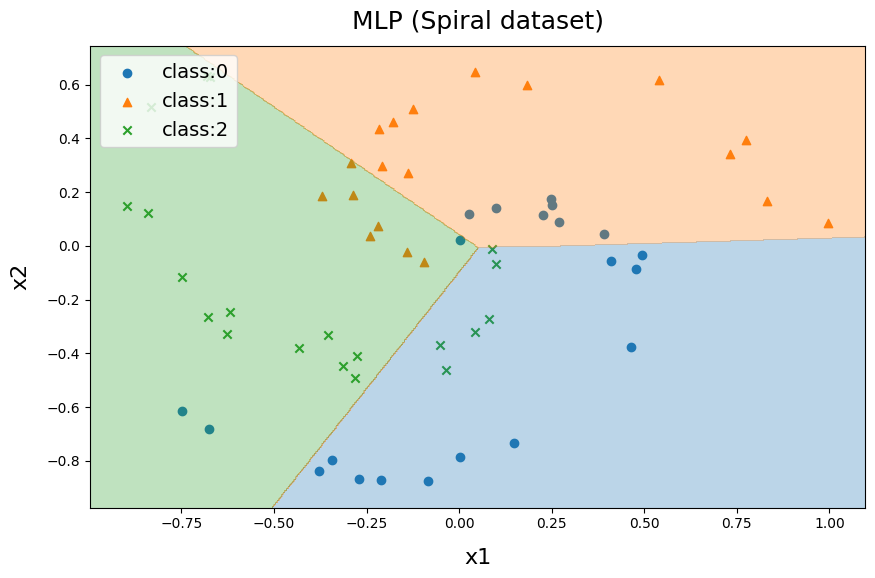

In [20]:
x1_mesh, x2_mesh, y_mesh = compute_decision_boundary_mlp(x_test, slp, resolution=500)
plot_spiral(x_test, y_test, x1_mesh, x2_mesh, y_mesh)

### 2.7. Train multi-layer MLP

In [21]:
mlp = train_mlp(x_train, x_test, y_train, y_test, features=[2, 10, 3], lr=1e-2, epochs=500, log_every=50)

Epochs: 50/500, loss (test): 0.8058, accuracy (test): 0.6333
Epochs: 100/500, loss (test): 0.3486, accuracy (test): 0.8833
Epochs: 150/500, loss (test): 0.2998, accuracy (test): 0.8667
Epochs: 200/500, loss (test): 0.5130, accuracy (test): 0.7667
Epochs: 250/500, loss (test): 0.1895, accuracy (test): 0.9500
Epochs: 300/500, loss (test): 0.1703, accuracy (test): 0.9333
Epochs: 350/500, loss (test): 0.1619, accuracy (test): 0.9333
Epochs: 400/500, loss (test): 0.1945, accuracy (test): 0.9167
Epochs: 450/500, loss (test): 0.1695, accuracy (test): 0.9333
Epochs: 500/500, loss (test): 0.1537, accuracy (test): 0.9500


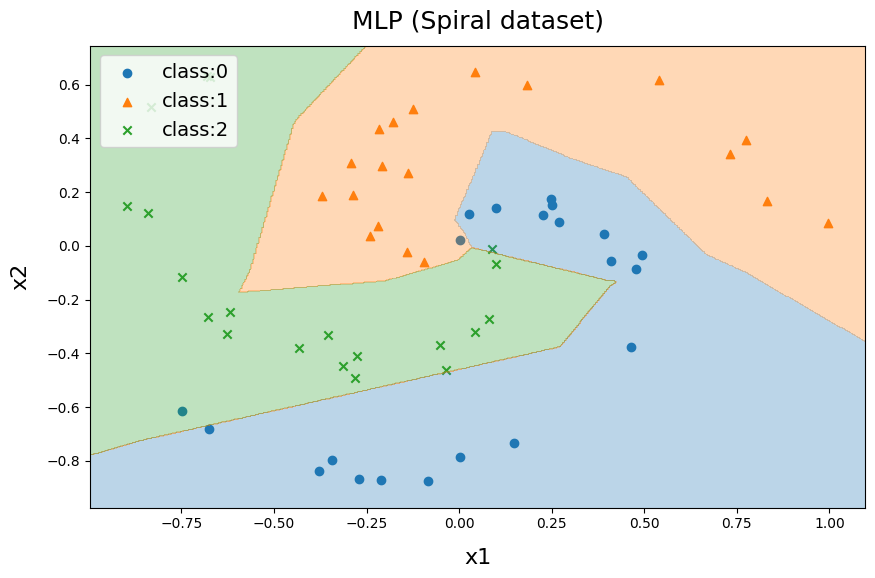

In [22]:
x1_mesh, x2_mesh, y_mesh = compute_decision_boundary_mlp(x_test, mlp, resolution=500)
plot_spiral(x_test, y_test, x1_mesh, x2_mesh, y_mesh)

## 3. References
[https://cs231n.github.io/neural-networks-case-study/](https://cs231n.github.io/neural-networks-case-study/)
